In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
import joblib

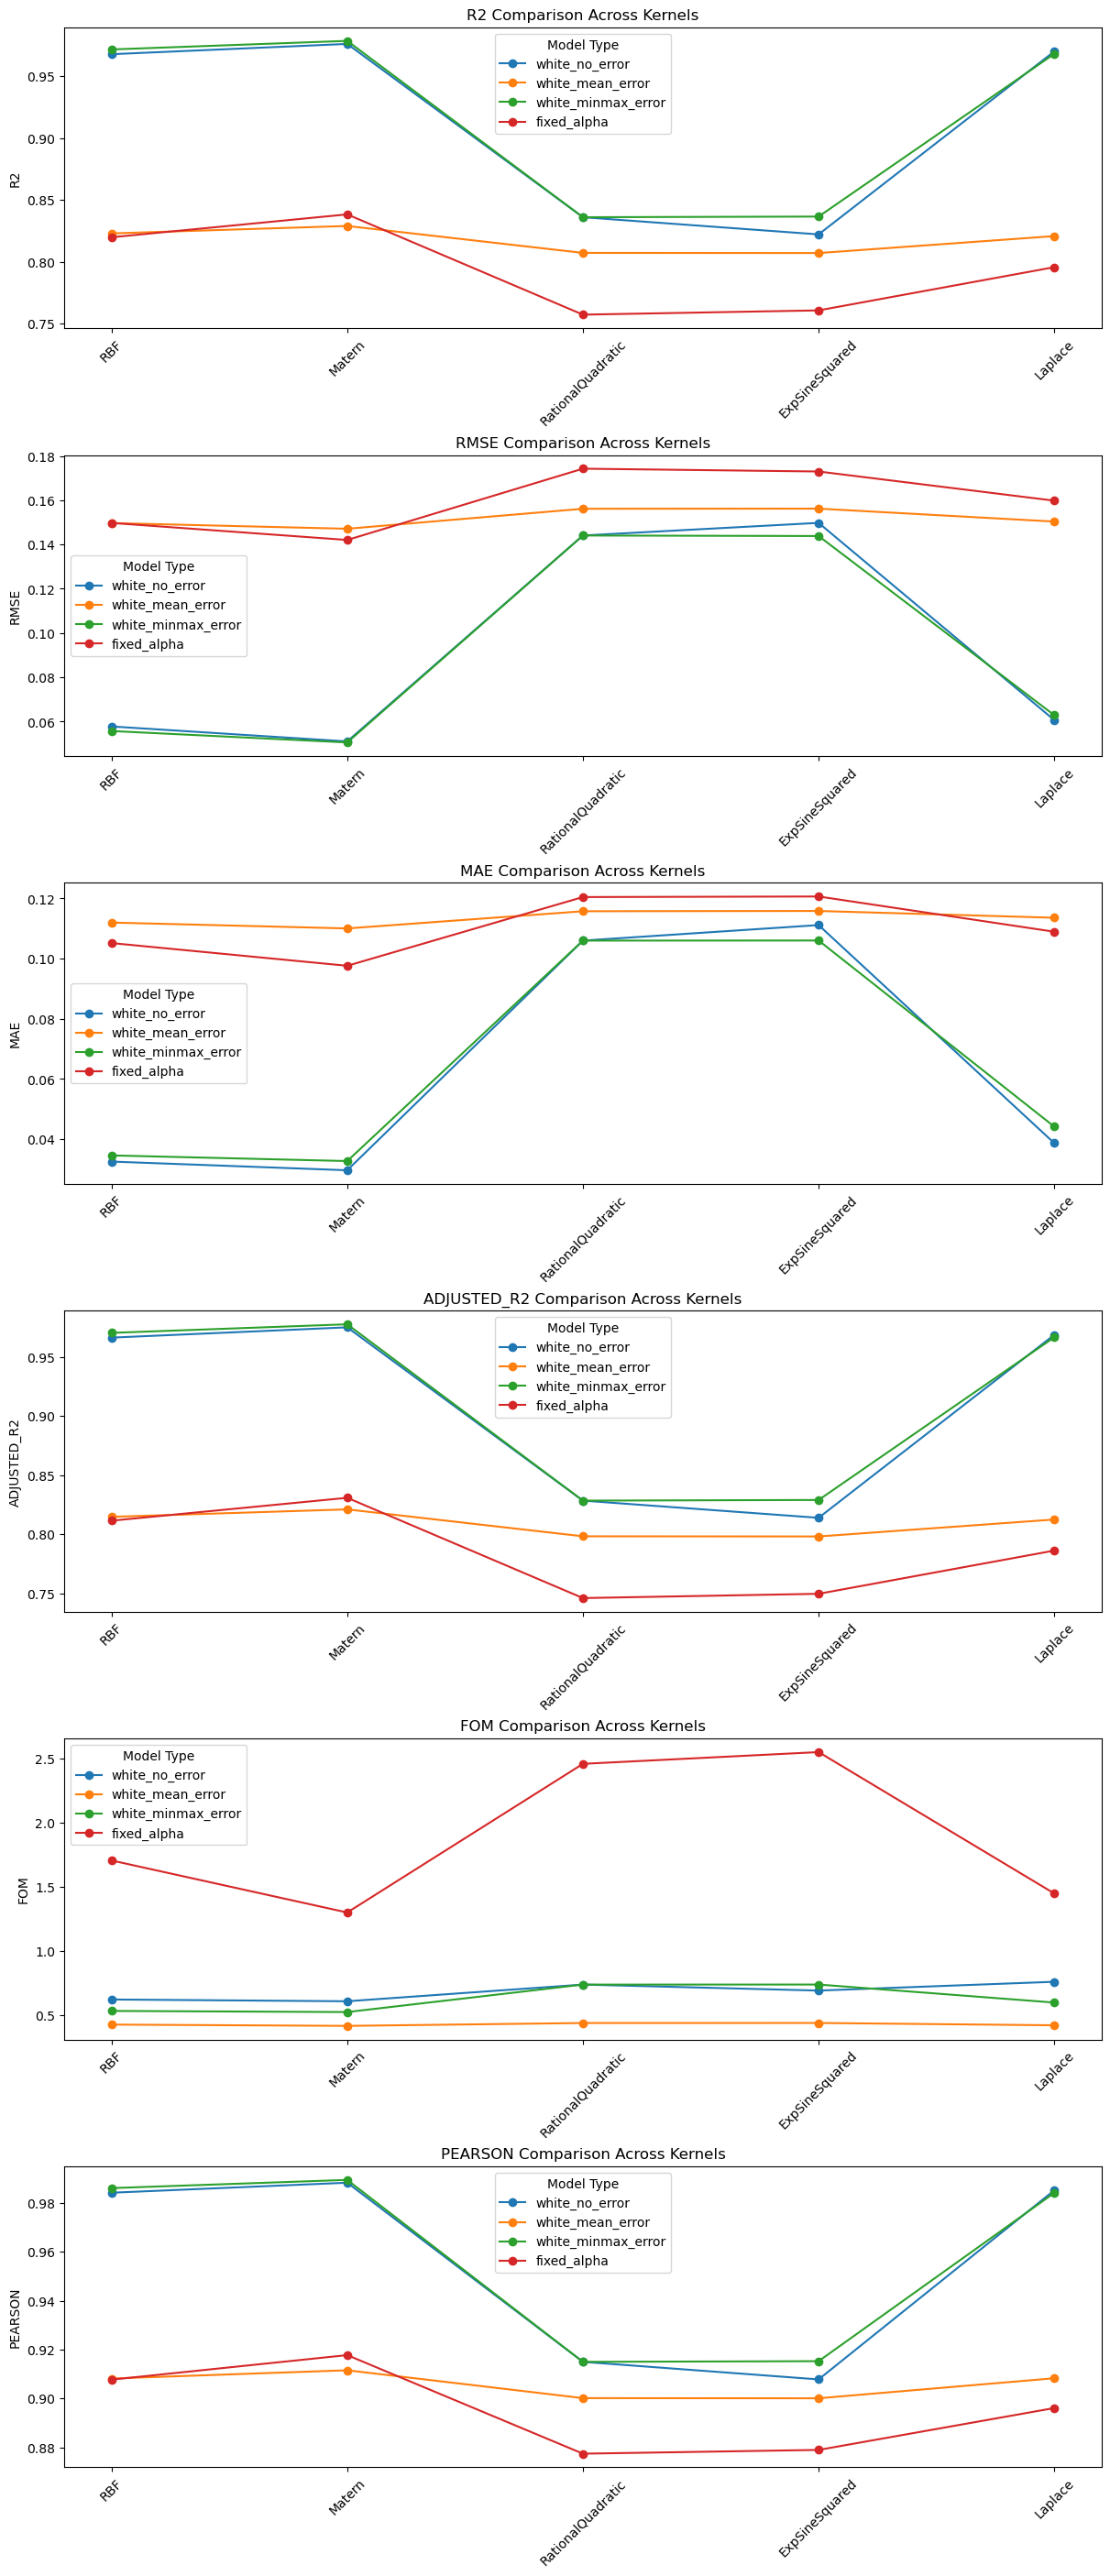

In [2]:
# Lists and data already defined
cv_results_all_kernels = joblib.load('cv_results_all_kernels.pkl')
kernel_names = ['RBF', 'Matern', 'RationalQuadratic', 'ExpSineSquared', 'Laplace']
modeltypes = ['white_no_error', 'white_mean_error', 'white_minmax_error','fixed_alpha']
metrics = ['r2', 'rmse', 'mae', 'adjusted_r2', 'fom', 'pearson']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for modeltypes (not kernels)

# Plot setup
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(12, 28), constrained_layout=True)

x_ticks = np.arange(len(kernel_names))

# Loop over each metric (one subplot per metric)
for i, metric in enumerate(metrics):
    ax = axes[i]  # Current axis for this metric

    # Plot each model type (line across kernels)
    for j, modeltype in enumerate(modeltypes):
        # Collect metric means across kernels for this model type
        metric_values = [np.mean(cv_results_all_kernels[kernel][modeltype][metric]) for kernel in kernel_names]

        # Plot the line for this model type
        ax.plot(x_ticks, metric_values, '-o', label=modeltype, color=colors[j])

    # Axis labels and formatting
    ax.set_title(f'{metric.upper()} Comparison Across Kernels')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(kernel_names, rotation=45, fontsize=10)
    ax.set_ylabel(f'{metric.upper()}')
    ax.legend(title='Model Type', fontsize=10)

plt.show()

### Final is the Clearly the Matern, RBF and Laplace kernels for all methods
### We keep the point estimate alpha = Err^2 and then test the white kernels seperately
### We have the rbf matern laplace. We score each kernel and each method to find the best combinations
### 

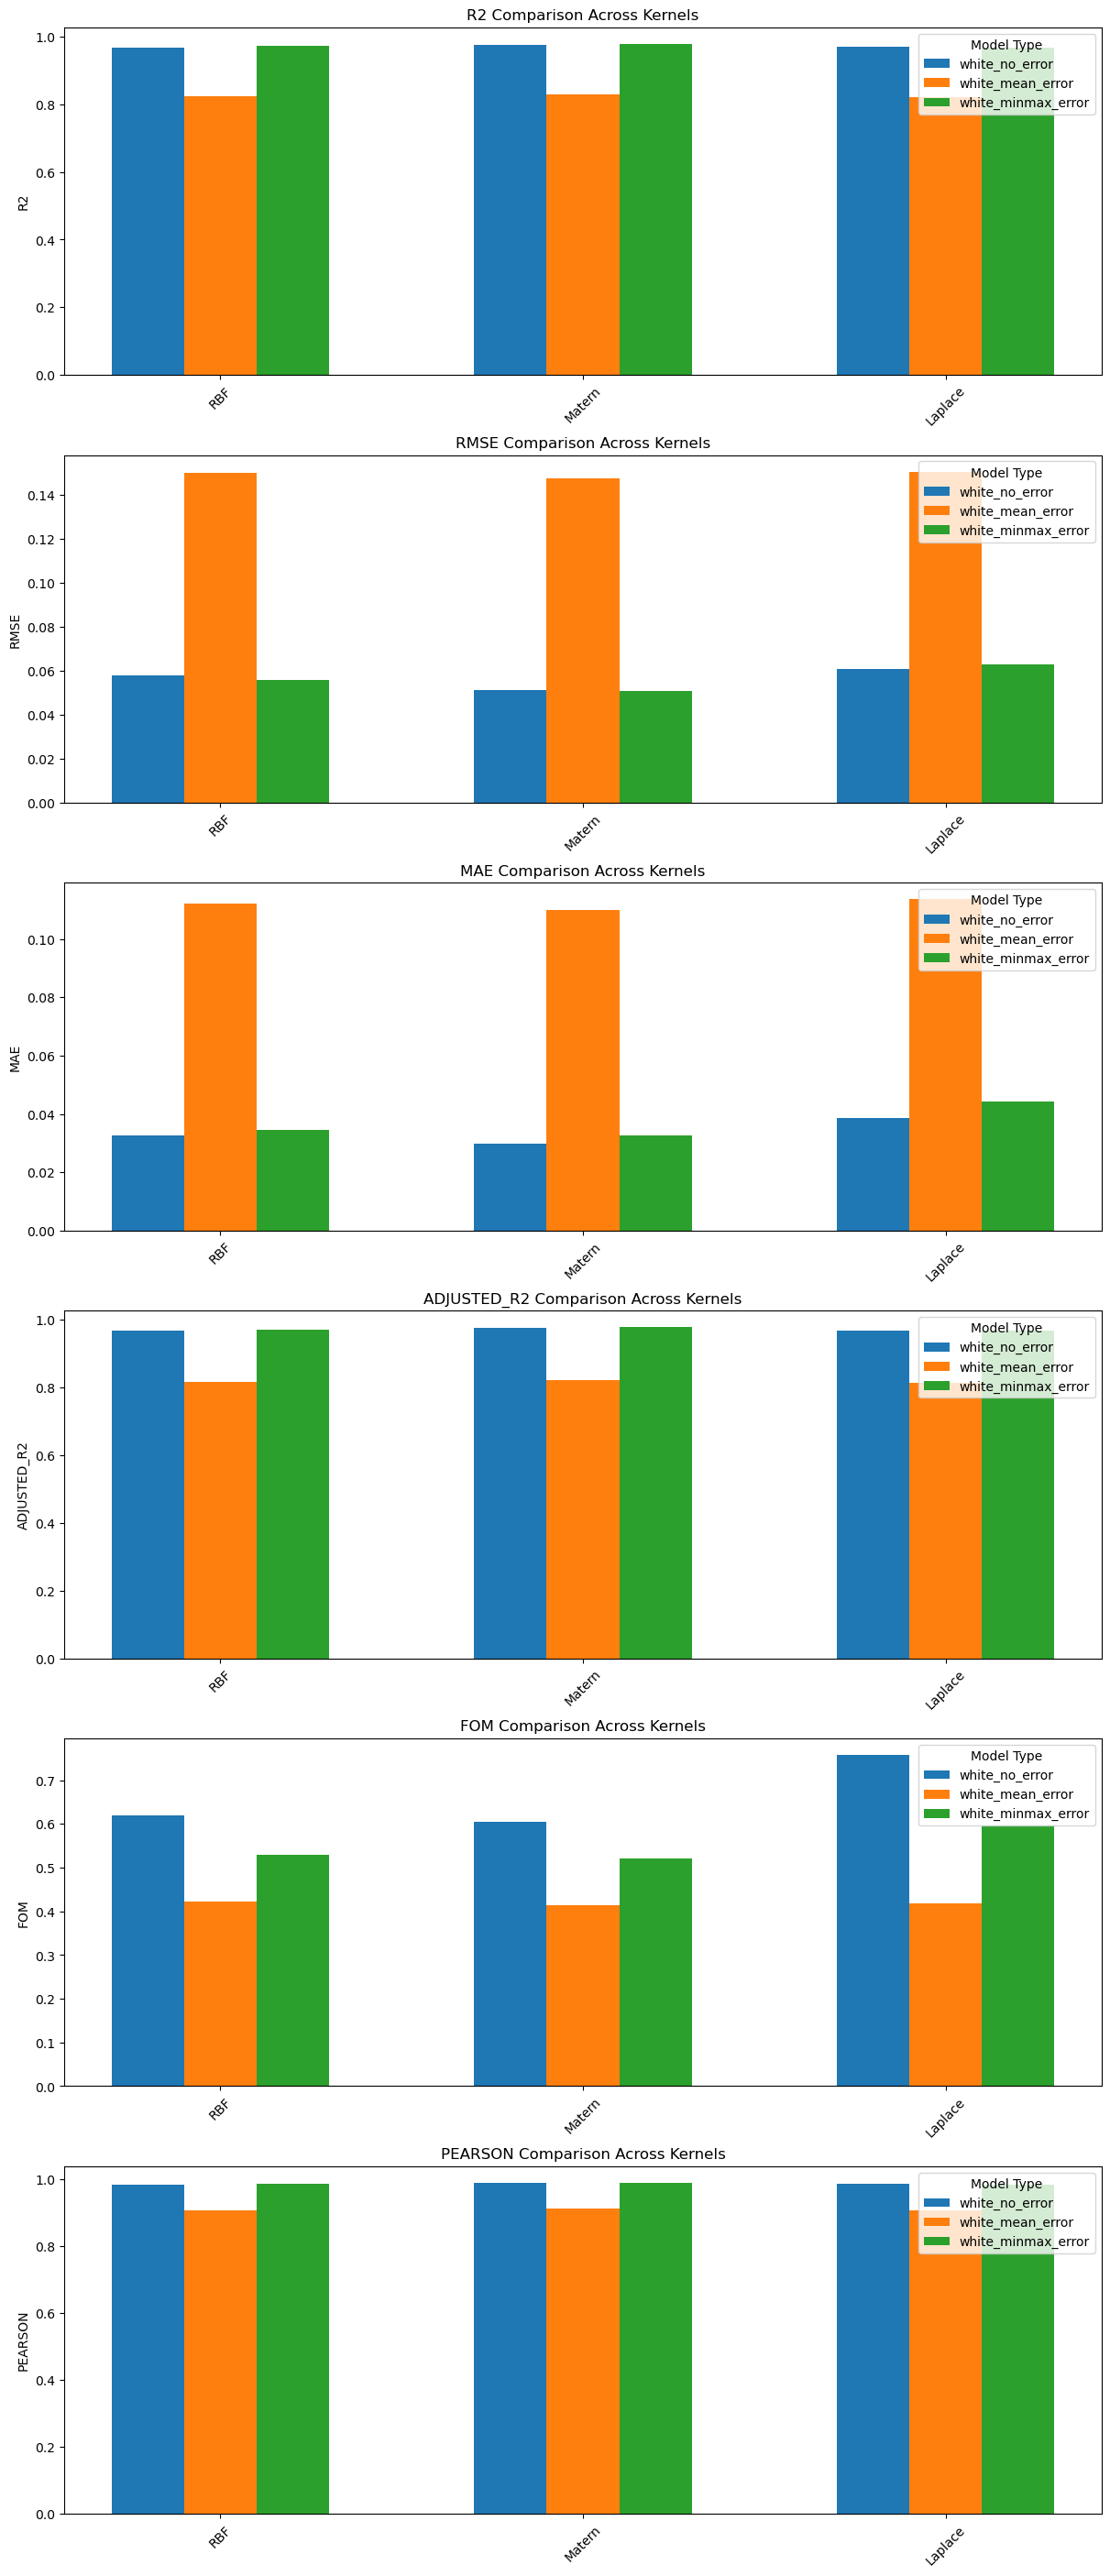

In [5]:
# Lists and data already defined
cv_results_all_kernels = joblib.load('cv_results_all_kernels.pkl')
kernel_names = ['RBF', 'Matern', 'Laplace']
modeltypes = ['white_no_error', 'white_mean_error', 'white_minmax_error']#, 'fixed_alpha']
metrics = ['r2', 'rmse', 'mae', 'adjusted_r2', 'fom', 'pearson']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for modeltypes (not kernels)

# Plot setup
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(12, 28), constrained_layout=True)

x_ticks = np.arange(len(kernel_names))
bar_width = 0.2

# Loop over each metric (one subplot per metric)
for i, metric in enumerate(metrics):
    ax = axes[i]  # Current axis for this metric

    # Plot each model type (line across kernels)
    for j, modeltype in enumerate(modeltypes):
        # Collect metric means across kernels for this model type
        metric_values = [np.mean(cv_results_all_kernels[kernel][modeltype][metric]) for kernel in kernel_names]

        # Plot the line for this model type
        # Shift bars for this modeltype using bar_width
        x_pos = x_ticks + j * bar_width - (bar_width * (len(modeltypes) - 1) / 2)  # Center bars around kernel tick

        # Plot bar
        ax.bar(x_pos, metric_values, width=bar_width, label=modeltype, color=colors[j])
        #ax.set_ylim(min(metric_values)-0.05, max(metric_values)+0.01)

    # Axis labels and formatting
    ax.set_title(f'{metric.upper()} Comparison Across Kernels')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(kernel_names, rotation=45, fontsize=10)
    ax.set_ylabel(f'{metric.upper()}')
    ax.legend(title='Model Type', fontsize=10)

plt.show()

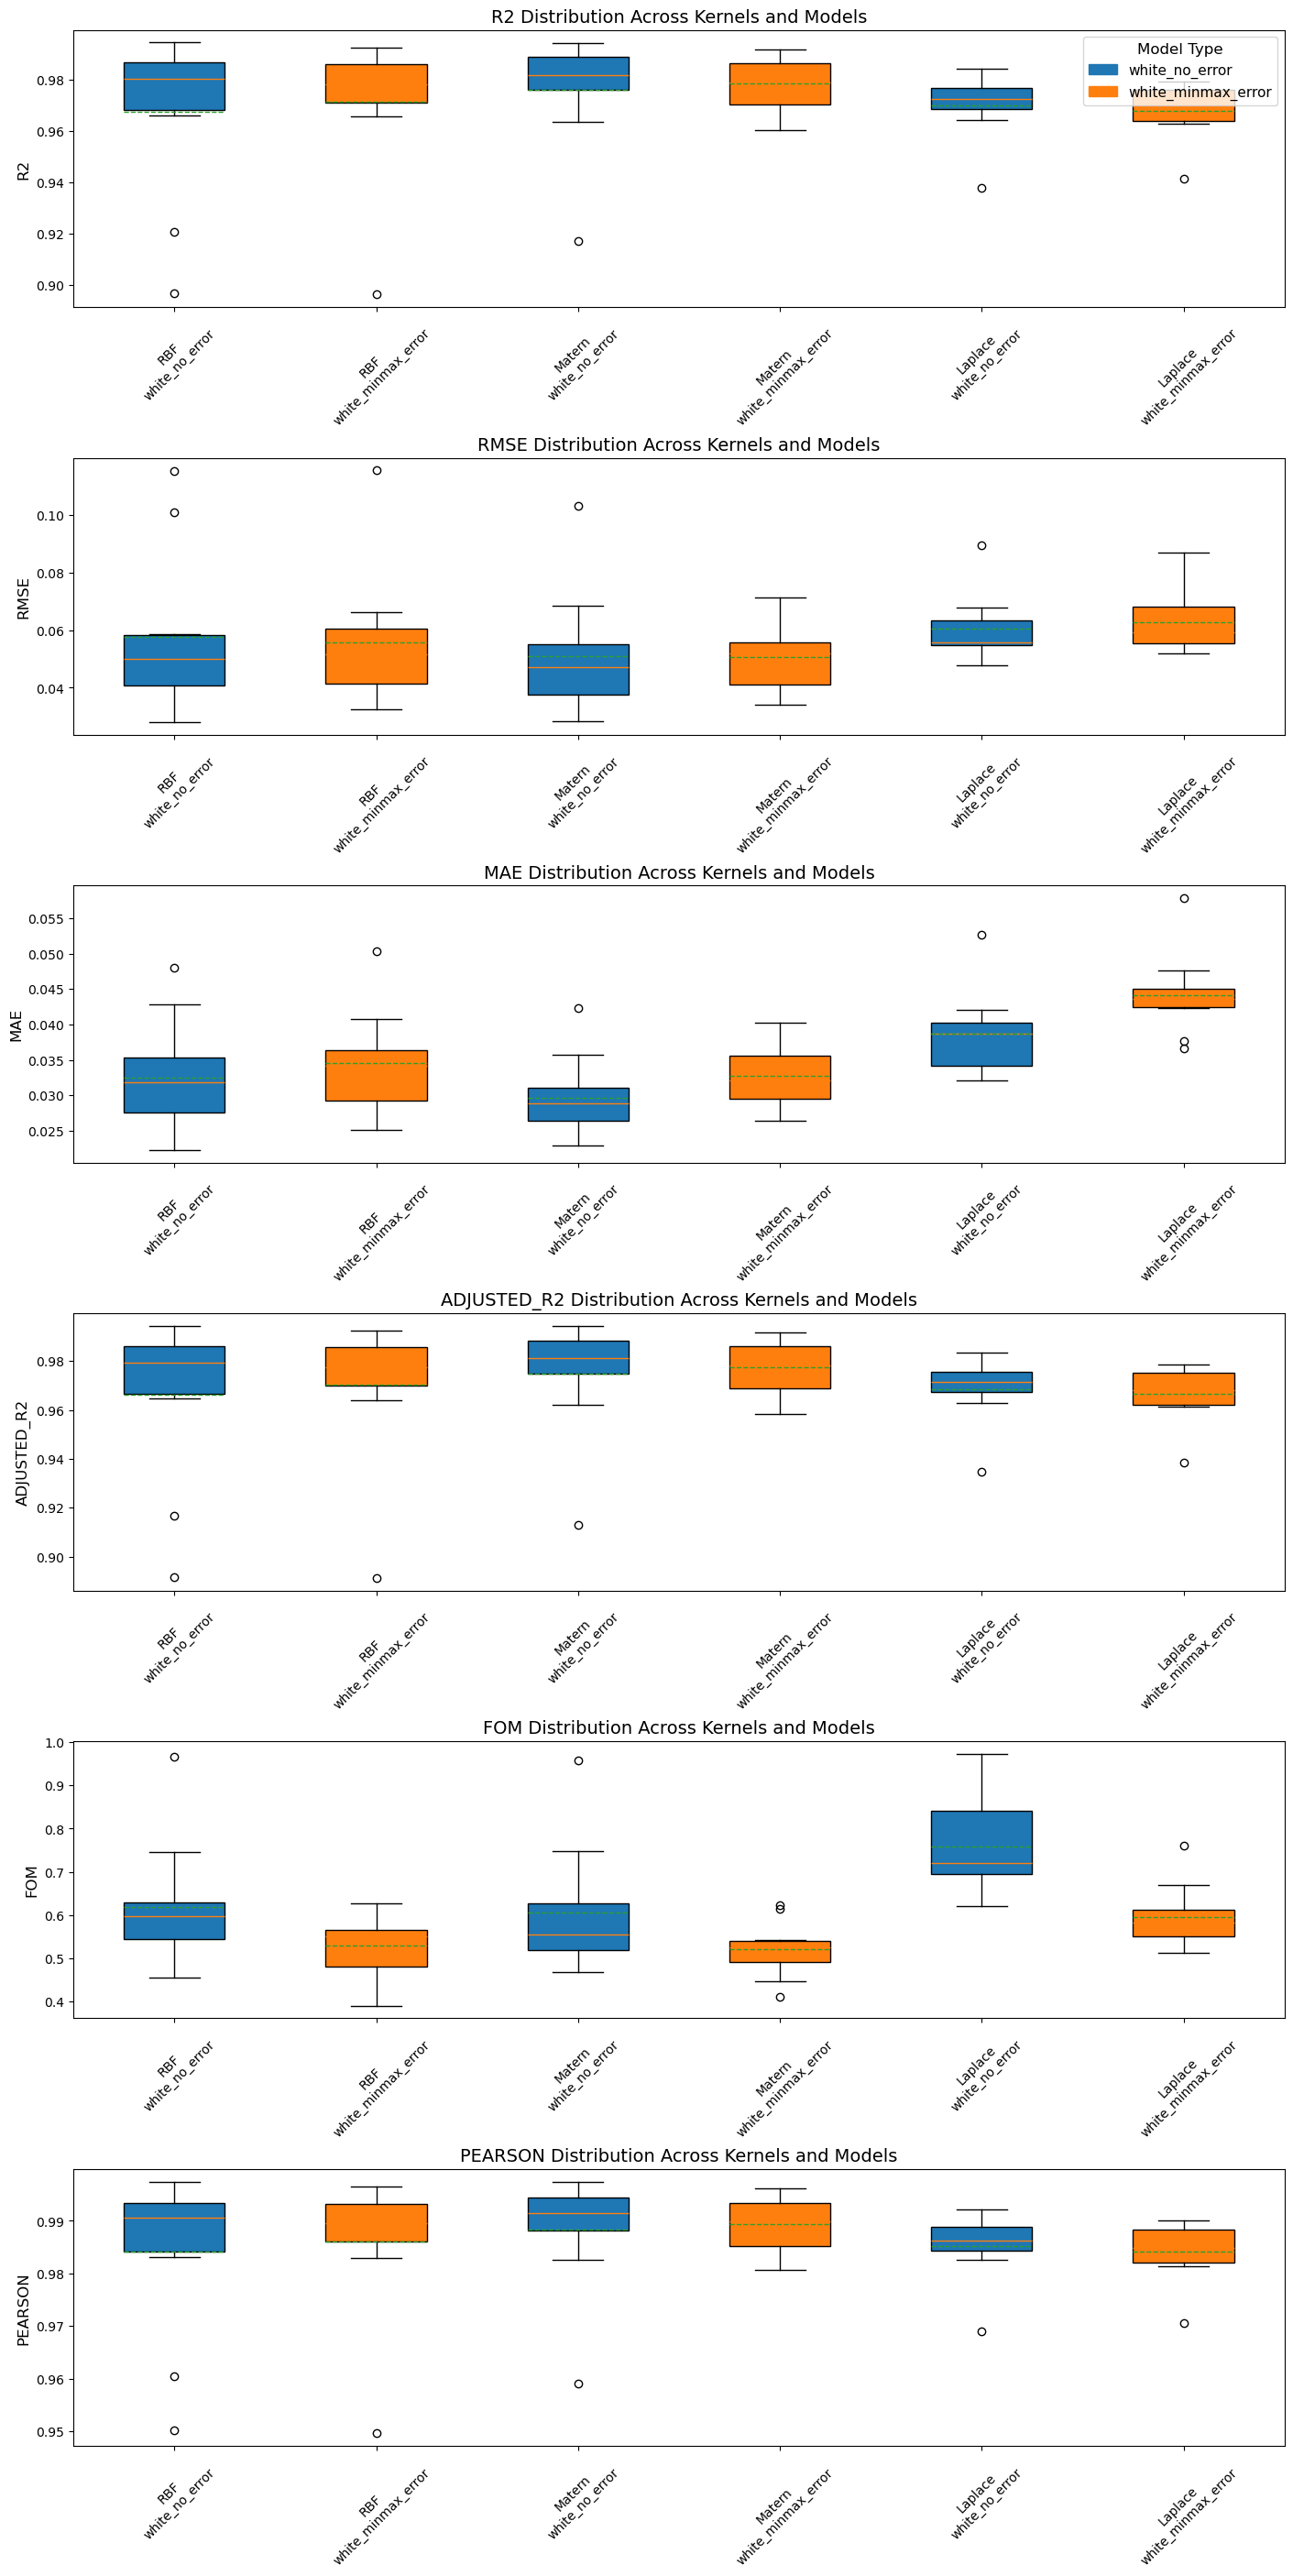

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Load results (assuming it's already available)
cv_results_all_kernels = joblib.load('cv_results_all_kernels.pkl')

# Definitions
kernel_names = ['RBF', 'Matern', 'Laplace']
modeltypes = ['white_no_error', 'white_minmax_error']  # Add 'fixed_alpha' if needed
metrics = ['r2', 'rmse', 'mae', 'adjusted_r2', 'fom', 'pearson']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Adjust/add colors if more modeltypes

# Plot setup
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(14, 28), constrained_layout=True)

# Loop over each metric (one subplot per metric)
for i, metric in enumerate(metrics):
    ax = axes[i]  # Current axis for this metric

    box_data = []  # Data for boxplot
    box_labels = []  # Labels for boxplot
    color_patches = []  # Legend handles

    # Collect data for each kernel-modeltype pair
    for kernel in kernel_names:
        for j, modeltype in enumerate(modeltypes):
            # Get all CV fold values for this kernel-modeltype-metric
            values = cv_results_all_kernels[kernel][modeltype][metric]  # Assuming this is a list of per-fold scores

            box_data.append(values)
            box_labels.append(f"{kernel}\n{modeltype}")

    # Plot boxplot
    bplot = ax.boxplot(box_data, patch_artist=True, labels=box_labels, showmeans=True, meanline=True)

    # Coloring boxes
    for patch, label in zip(bplot['boxes'], box_labels):
        # Assign color based on modeltype
        for j, modeltype in enumerate(modeltypes):
            if modeltype in label:
                patch.set_facecolor(colors[j])
                break

    # Axis labels and formatting
    ax.set_title(f'{metric.upper()} Distribution Across Kernels and Models', fontsize=14)
    ax.set_ylabel(f'{metric.upper()}', fontsize=12)
    ax.tick_params(axis='x', rotation=45)

    # Legend (create patches only once)
    if i == 0:  # First plot, add legend
        from matplotlib.patches import Patch
        legend_handles = [Patch(color=colors[j], label=modeltype) for j, modeltype in enumerate(modeltypes)]
        ax.legend(handles=legend_handles, title='Model Type', fontsize=11, title_fontsize=12, loc='upper right')

plt.show()


#### Make 9 boxplots here now also one for each model

In [12]:
# Load your results
cv_results_all_kernels = joblib.load('cv_results_all_kernels.pkl')

# Define lists
kernel_names = ['RBF', 'Matern', 'Laplace']
modeltypes = ['white_no_error', 'white_minmax_error']
metrics = ['r2', 'rmse', 'mae', 'adjusted_r2', 'fom', 'pearson']

# Collect all (kernel, modeltype) combinations
models = []
for kernel in kernel_names:
    for modeltype in modeltypes:
        models.append((kernel, modeltype))

# Initialize dictionary to hold ranks per metric
ranks = {metric: [] for metric in metrics}

# --- Rank each metric ---
for metric in metrics:
    # Collect metric values for all models
    metric_values = []
    for kernel, modeltype in models:
        value = np.mean(cv_results_all_kernels[kernel][modeltype][metric])
        metric_values.append(value)

    # Convert to numpy array for easy handling
    metric_array = np.array(metric_values)

    # Decide whether higher or lower is better
    if metric in ['r2', 'adjusted_r2', 'pearson']:  # Higher is better
        order = metric_array.argsort()[::-1]  # Descending order
    else:  # Lower is better (rmse, mae, fom)
        order = metric_array.argsort()  # Ascending order

    # Assign ranks based on sorted order
    rank_array = np.empty_like(order)
    rank_array[order] = np.arange(1, len(order) + 1)  # 1-based ranking

    # Store ranks
    ranks[metric] = rank_array

# --- Combine all ranks into a DataFrame ---
ranking_df = pd.DataFrame({
    'Kernel': [k for k, m in models],
    'Noise Model': [m for k, m in models]
})

# Add ranks per metric to DataFrame
for metric in metrics:
    ranking_df[f'{metric.upper()} Rank'] = ranks[metric]

# --- Compute average rank ---
ranking_df['Average Rank'] = ranking_df[[f'{m.upper()} Rank' for m in metrics]].mean(axis=1)

# --- Sort by average rank (lower is better) ---
ranking_df = ranking_df.sort_values('Average Rank').reset_index(drop=True)

# Display final ranking table
print("\nFinal Model Ranking Based on Average Ranks:\n")
print(ranking_df)



Final Model Ranking Based on Average Ranks:

    Kernel         Noise Model  R2 Rank  RMSE Rank  MAE Rank  \
0   Matern  white_minmax_error        1          1         3   
1   Matern      white_no_error        2          2         1   
2      RBF  white_minmax_error        3          3         4   
3      RBF      white_no_error        6          4         2   
4  Laplace      white_no_error        4          5         5   
5  Laplace  white_minmax_error        5          6         6   

   ADJUSTED_R2 Rank  FOM Rank  PEARSON Rank  Average Rank  
0                 1         1             1      1.333333  
1                 2         4             2      2.166667  
2                 3         2             3      3.000000  
3                 6         5             5      4.666667  
4                 4         6             4      4.666667  
5                 5         3             6      5.166667  



Pairwise Metric Distance Matrix:
                 r2   rmse    mae  adjusted_r2    fom  pearson
r2           0.000  0.171  0.686        0.000  0.400    0.057
rmse         0.171  0.000  0.286        0.171  0.457    0.057
mae          0.686  0.286  0.000        0.686  1.029    0.457
adjusted_r2  0.000  0.171  0.686        0.000  0.400    0.057
fom          0.400  0.457  1.029        0.400  0.000    0.514
pearson      0.057  0.057  0.457        0.057  0.514    0.000


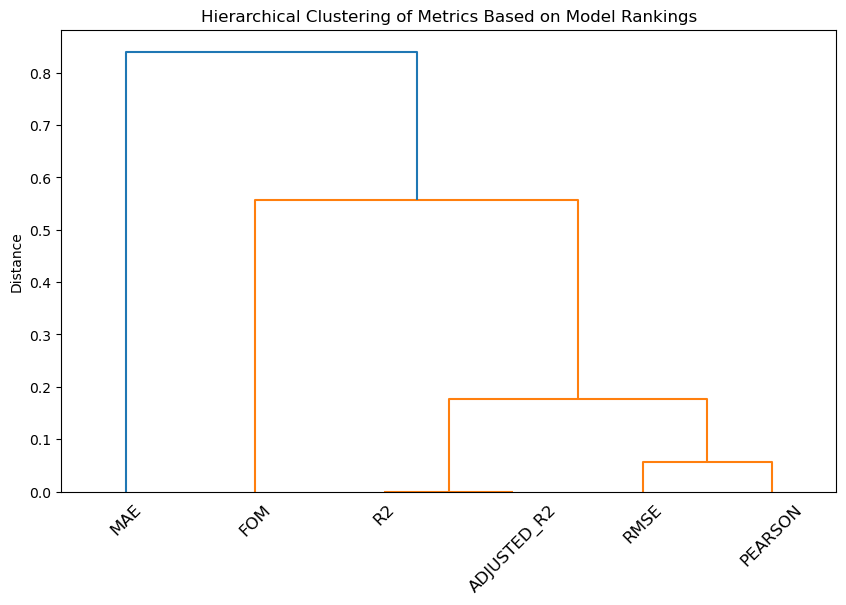

In [13]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# Assuming 'ranking_df' is your final DataFrame from your code
# and contains columns like 'R2 Rank', 'RMSE Rank', etc.

# Step 1: Extract rank data for each metric across models
metrics = ['r2', 'rmse', 'mae', 'adjusted_r2', 'fom', 'pearson']
rank_columns = [f'{metric.upper()} Rank' for metric in metrics]

# (n_models, n_metrics) matrix
rank_matrix = ranking_df[rank_columns].values.T  # shape: (n_metrics, n_models)

# Step 2: Compute distance matrix
# You can choose Euclidean or correlation distance, for example:
# distance_matrix = pdist(rank_matrix, metric='euclidean')  # Euclidean
distance_matrix = pdist(rank_matrix, metric='correlation')  # Correlation (1 - corr)

# Optional: See the pairwise distance matrix
distance_square = squareform(distance_matrix)
distance_df = pd.DataFrame(distance_square, index=metrics, columns=metrics)
print("\nPairwise Metric Distance Matrix:\n", distance_df.round(3))

# Step 3: Perform hierarchical clustering
linkage_matrix = linkage(distance_matrix, method='ward')  # 'ward' for variance minimization

# Step 4: Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(
    linkage_matrix,
    labels=[metric.upper() for metric in metrics],
    leaf_rotation=45,
    leaf_font_size=12,
    color_threshold=None,  # Adjust or leave None to color everything
)
plt.title("Hierarchical Clustering of Metrics Based on Model Rankings")
plt.ylabel("Distance")
plt.show()


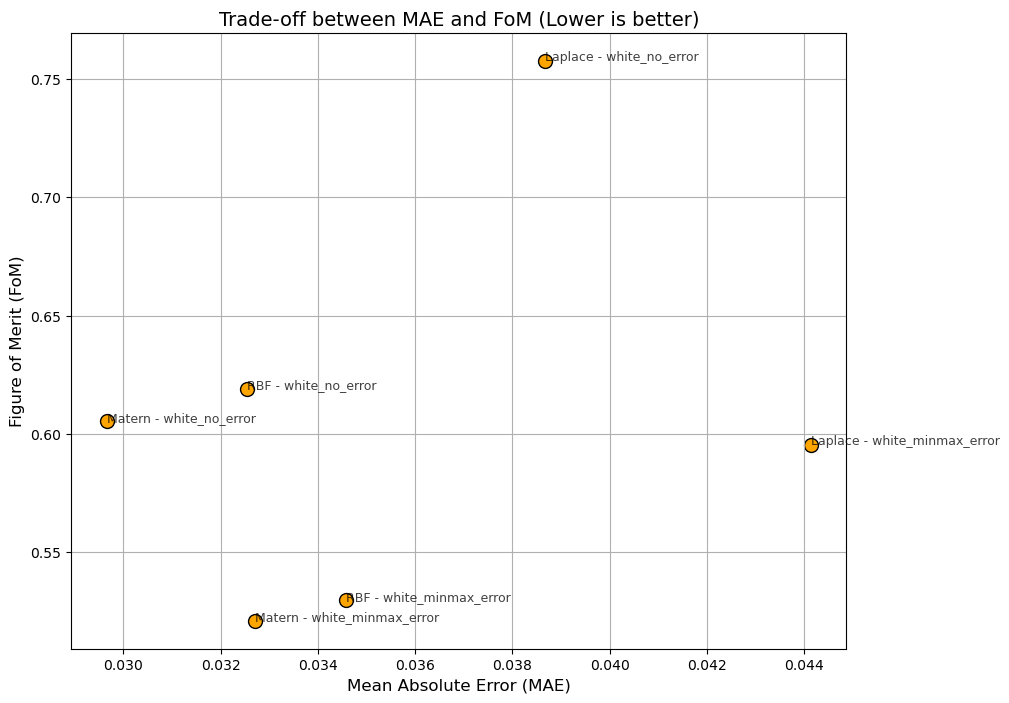

In [17]:
import matplotlib.pyplot as plt

# Collect data for trade-off
models = []
mae_list = []
fom_list = []

for kernel in kernel_names:
    for modeltype in modeltypes:
        mae = np.mean(cv_results_all_kernels[kernel][modeltype]['mae'])
        fom = np.mean(cv_results_all_kernels[kernel][modeltype]['fom'])
        models.append(f'{kernel} - {modeltype}')  # Label for each point
        mae_list.append(mae)
        fom_list.append(fom)

# Plot trade-off
plt.figure(figsize=(10, 8))
plt.scatter(mae_list, fom_list, s=100, color='orange', edgecolor='k')

# Annotate points with model names
for i, label in enumerate(models):
    plt.annotate(label, (mae_list[i], fom_list[i]), fontsize=9, alpha=0.75)

plt.xlabel('Mean Absolute Error (MAE)', fontsize=12)
plt.ylabel('Figure of Merit (FoM)', fontsize=12)
plt.title('Trade-off between MAE and FoM (Lower is better)', fontsize=14)
plt.grid(True)
plt.show()


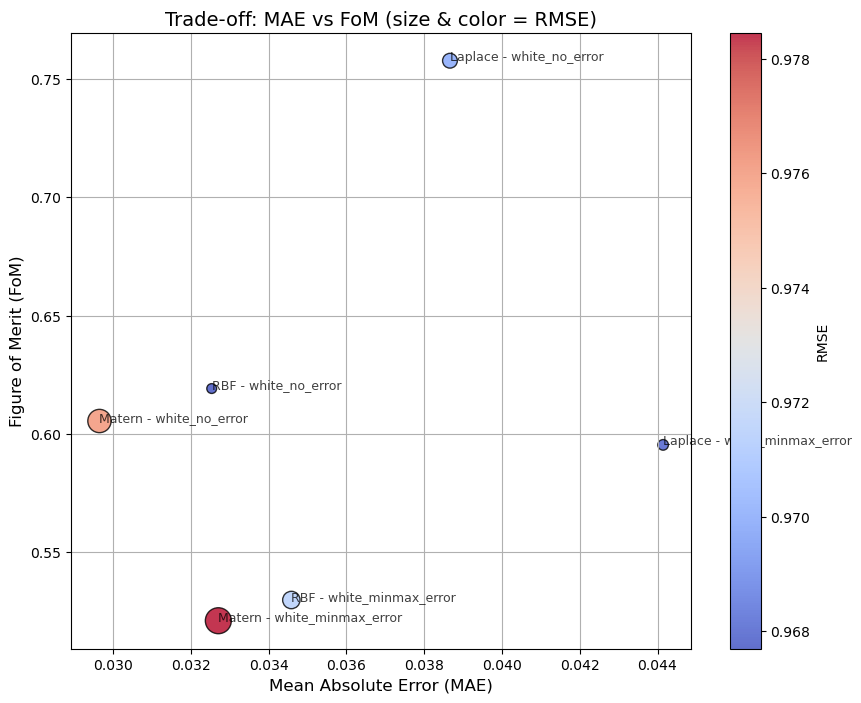

In [15]:
import numpy as np

# Collect RMSE for color/size
rmse_list = [np.mean(cv_results_all_kernels[kernel][modeltype]['r2'])
             for kernel in kernel_names for modeltype in modeltypes]

# Normalize RMSE for visualization
rmse_array = np.array(rmse_list)
rmse_norm = (rmse_array - rmse_array.min()) / (rmse_array.max() - rmse_array.min()) * 300 + 50  # size scaling

# Scatter with color and size based on RMSE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(mae_list, fom_list, s=rmse_norm, c=rmse_array, cmap='coolwarm', edgecolor='k', alpha=0.8)

# Annotate
for i, label in enumerate(models):
    plt.annotate(label, (mae_list[i], fom_list[i]), fontsize=9, alpha=0.75)

plt.xlabel('Mean Absolute Error (MAE)', fontsize=12)
plt.ylabel('Figure of Merit (FoM)', fontsize=12)
plt.title('Trade-off: MAE vs FoM (size & color = RMSE)', fontsize=14)
plt.colorbar(scatter, label='RMSE')
plt.grid(True)
plt.show()
